In [3]:
import tensorflow as tf
source = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
model_dir = tf.keras.utils.get_file(fname='ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',origin = source, untar=True)
print(model_dir)

/home/suhas/.keras/datasets/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8


In [4]:
model = tf.saved_model.load(model_dir+'/saved_model')

2023-03-15 13:21:05.790086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/suhas/openvino_env/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 13:21:05.791132: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 13:21:05.791287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Magnus): /proc/driver/nvidia/version does not exist
2023-03-15 13:21:05.795062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
signature = model.signatures['serving_default']

In [6]:
import numpy as np
import cv2
# Load an image from a file
image = cv2.imread('Screenshot 2023-03-10 190018.jpg')

# Convert the image from BGR to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_untouched = image.copy()

# Resize the image to 320x320 pixels
image = cv2.resize(image, (320, 320))

# Convert the image to a float32 tensor
image = tf.convert_to_tensor(image, dtype=tf.uint8)

# Add a batch dimension to the tensor
image = tf.expand_dims(image, axis=0)

output_tensor = signature(image)


2023-03-15 13:21:36.460628: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9830400 exceeds 10% of free system memory.


In [7]:
import matplotlib.pyplot as plt
box = output_tensor['detection_boxes']
classes = output_tensor['detection_classes']
scores = output_tensor['detection_scores']
num_detections = output_tensor['num_detections']
import re

# Open the label map file and read its contents
with open('mscoco_label_map.pbtxt', 'r') as f:
    label_map_data = f.read()

# Define a regular expression pattern to extract item entries
item_pattern = re.compile(r'item\s*\{(.*?)\}', re.DOTALL)

# Find all item entries in the label map data
items = item_pattern.findall(label_map_data)

# Create a dictionary to map class ids to display names
id_to_display_name = {}

# Iterate over all item entries
for item in items:
    # Extract the id and display_name fields from the item entry
    id_match = re.search(r'id\s*:\s*(\d+)', item)
    display_name_match = re.search(r'display_name\s*:\s*"(.+?)"', item)

    if id_match and display_name_match:
        # Get the id and display_name values
        id_value = int(id_match.group(1))
        display_name_value = display_name_match.group(1)

        # Add an entry to the dictionary mapping the id to the display name
        id_to_display_name[id_value] = display_name_value

# Get the display name for a specific class id
class_id = 1  # Example class id
display_name = id_to_display_name[class_id]
print(display_name)


    
    




person


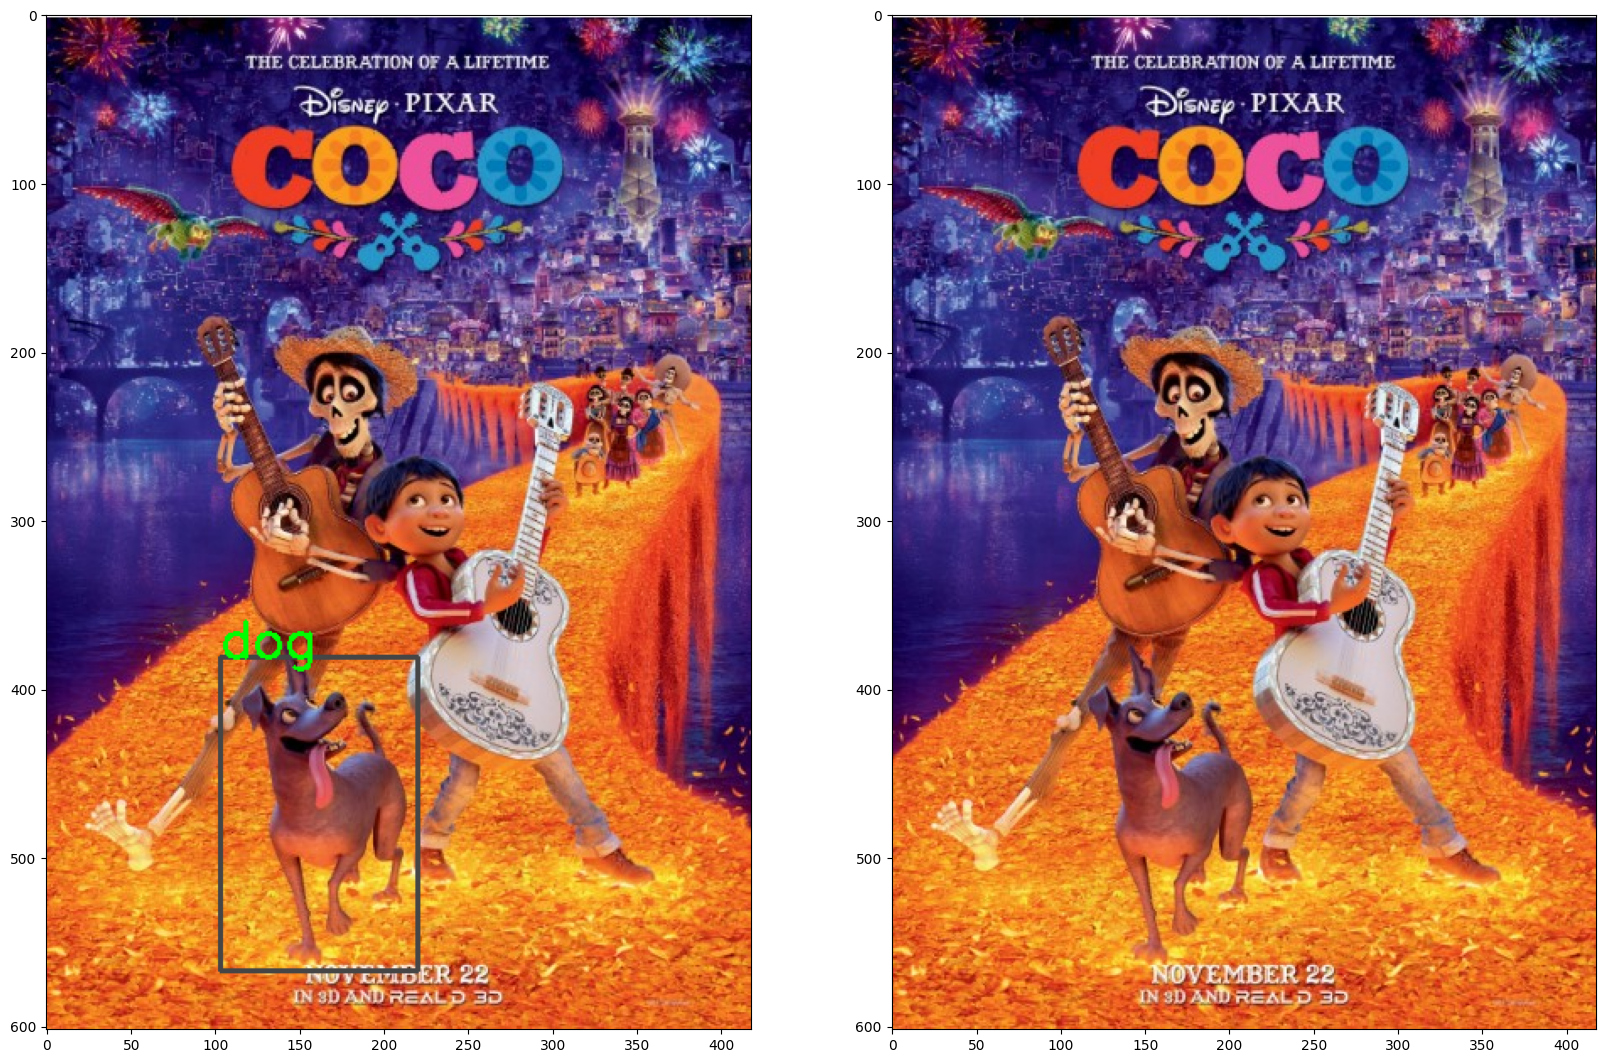

In [8]:
image = cv2.imread('Screenshot 2023-03-10 190018.jpg')
confidence_threshold = 0.7
for i in range(int(num_detections[0])):
    if scores[0][i] > confidence_threshold:
        boxes = box[0][i]
        x1 = int(boxes[1] * image.shape[1])
        y1 = int(boxes[0] * image.shape[0])
        x2 = int(boxes[3] * image.shape[1])
        y2 = int(boxes[2] * image.shape[0])
        class_id = int(classes[0][i])
        display_name = id_to_display_name.get(class_id, f'Label unavailable, class number: {class_id}')
        cv2.rectangle(image, (x1, y1), (x2, y2), (69, 69, 69), 2)
        cv2.putText(image, display_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
fig, axs = plt.subplots(1, 2,figsize=(20, 20))

axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[1].imshow(image_untouched)
plt.show()


In [9]:
from IPython.display import Markdown
mo_command = f"""mo
                 --saved_model_dir "{model_dir+'/saved_model'}"
                 --input_shape "[1,320,320,3]"
                 --model_name "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
                 --tensorflow_object_detection_api_pipeline_config "{model_dir+'/pipeline.config'}"
                 --output_dir "./model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
                 --transformations_config "ssd_support_api_v2.0.json"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --saved_model_dir "/home/suhas/.keras/datasets/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model" --input_shape "[1,320,320,3]" --model_name "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8" --tensorflow_object_detection_api_pipeline_config "/home/suhas/.keras/datasets/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config" --output_dir "./model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8" --transformations_config "ssd_support_api_v2.0.json"`

In [ ]:
imprt time
start = time.start()
! $mo_command
end = time.end()

In [10]:
from openvino.inference_engine import IECore
ie = IECore()
model = ie.read_network('./model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.xml','./model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.bin')
input_name = next(iter(model.input_info))
input_data = model.input_info[input_name].input_data
input_shape = input_data.shape # [1, 3, 300, 300]
input_layout = input_data.layout # NCHW
input_size = (input_shape[2], input_shape[3]) # (300, 300)
model = ie.load_network(network = model,device_name = "CPU",num_requests =1)

In [11]:

import cv2
image = cv2.imread('Screenshot 2023-03-10 190018.jpg')

# Preprocess image
image = cv2.resize(image, (320,320))
image = image.transpose((2,0,1))
image = image.reshape([1,3,320,320])

# Run inference
result = model.infer({input_name:image})


In [14]:
detections = result["DetectionOutput"]

In [36]:
def draw_bounding_boxes(image, detections, classes, threshold=0.5):
    # Get image dimensions
    

    # Iterate through detections
    no_detections = detections.shape[2]
    for i in range(no_detections):

        detection = detections[0, 0, i]

        # Skip detections with confidence below threshold
        confidence = detection[2]
        if confidence < threshold:
            continue

        # Draw bounding box
        x_min = int(detection[3]*image.shape[1])
        y_min = int(detection[4]*image.shape[0])

        x_max = int(detection[5]*image.shape[1])
        y_max = int(detection[6]*image.shape[0])

        cv2.rectangle(image, (x_min,y_min),(x_max,y_max), (69,69,69), 2)

        # Get class text
        class_ = id_to_display_name.get((int(detection[1])), f'Label unavailable, class number: {class_id}')
        cv2.putText(image, class_, (x_min,y_min), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 1)

    return image

In [37]:
image = draw_bounding_boxes(cv2.imread('Screenshot 2023-03-10 190018.jpg'),detections,id_to_display_name)

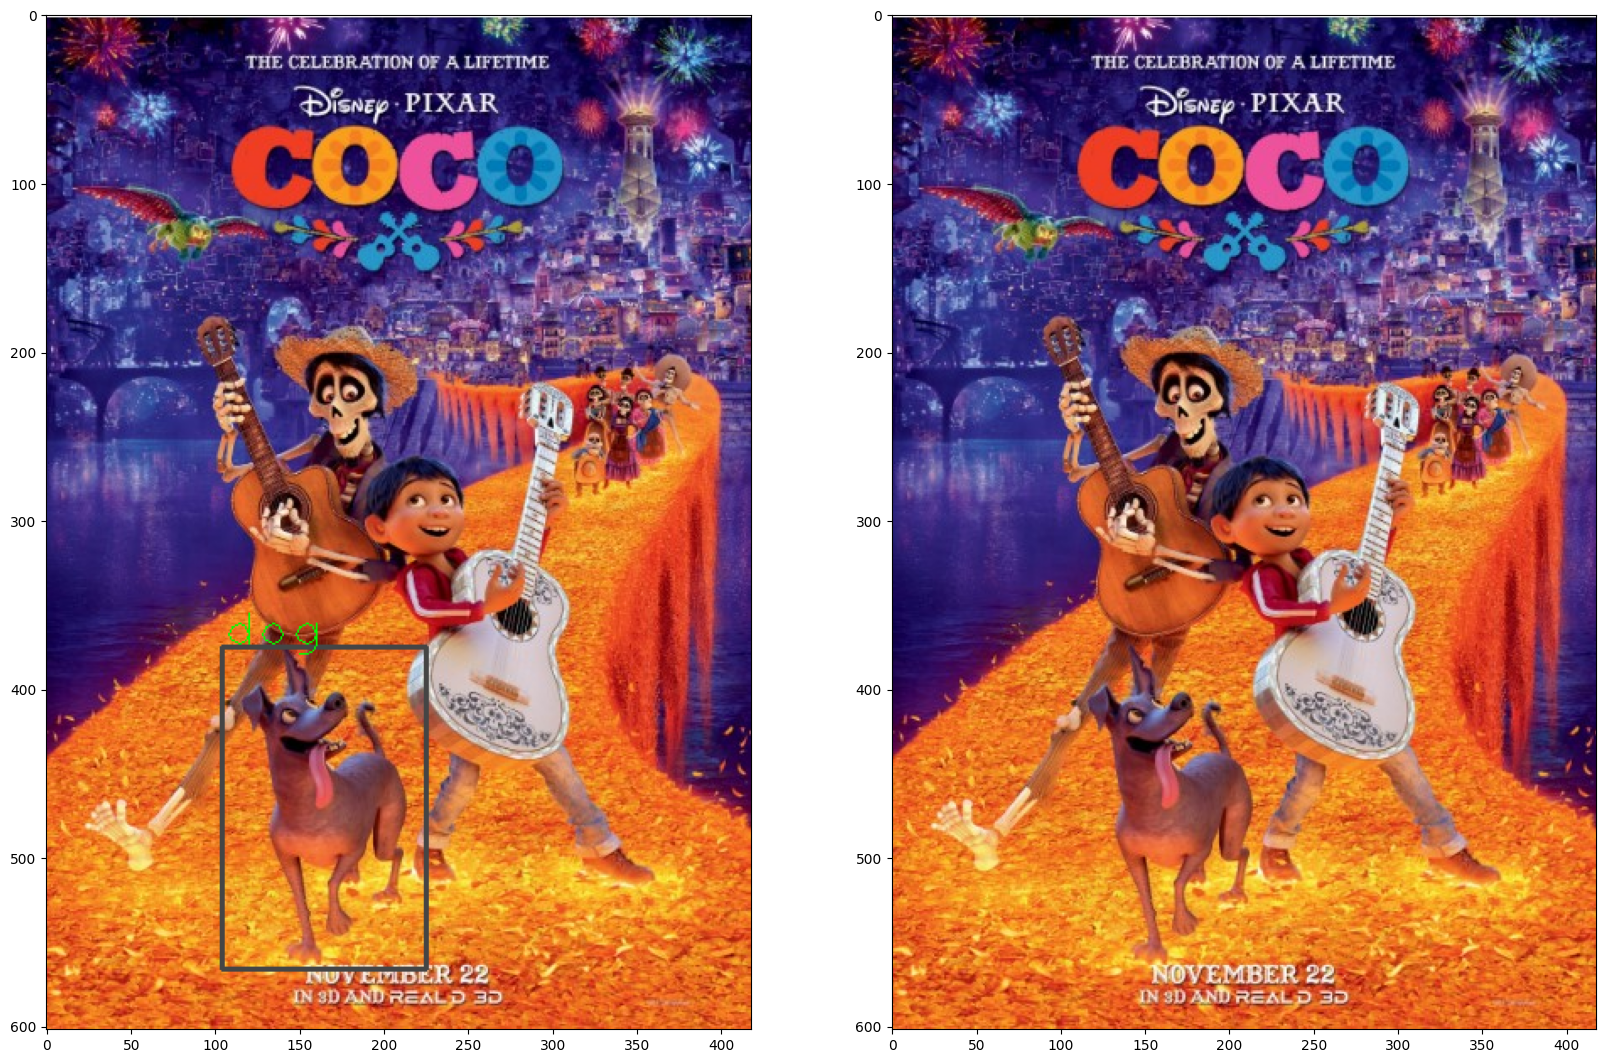

In [38]:
fig, axs = plt.subplots(1, 2,figsize=(20, 20))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[1].imshow(image_untouched)
plt.show()
